# **Parkinson Severity Classification: Inner Evaluation 2**

> **More exhaustive HPO over Random Forest using the top 10 feature extraction methods according to the first round  of the  inner evaluation**

This is the second round of the inner evaluation and is oriented to apply a more exhaustive HPO on Random Forest for the top 10 features extraction methods found on the previous round.

The idea is trying to find an even best version of Random Forest for carrying out our classification task. 

## **Requirements**

In [2]:
import numpy  as np
import polars as pl
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, StratifiedKFold
from itertools import combinations


In [4]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.evaluation import SimpleEvaluation

In [5]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private')
from PyAudio import get_X_audio_features

## **Data definition**

In this section we define the data to be used. Specifically we define the response variable and a set of predictors matrices to be used as different alternatives, each one associate to a combination of features extraction methods and statistics.

In [6]:
files_list_name = 'Files_List.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'level'])

We define the parameters to be used by the features extraction methods.

In [7]:
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In the next cell we define the response variable (target) and the different predictors matrices mentioned above.

In [ ]:
Y = files_df['level'].to_numpy()

simple_methods = ['MFCC', 'spectral_centroid', 'chroma', 'spectral_bandwidth', 
                  'spectral_contrast', 'spectral_rolloff', 'zero_crossing_rate', 'tempogram']

combined_methods = []

stats = ['mean-std', 'median-std', 'mean-median-std', 'mean-Q25-median-Q75-std']

sizes = range(2, len(simple_methods) + 1)

combined_methods = ['-'.join(sorted(combi)) for size in sizes for combi in combinations(simple_methods, size)]

X_stats, X_stats_train, X_stats_test = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in simple_methods:
    for stat in stats:

        X_stats[method][stat] = get_X_audio_features(paths=files_df['path'], method=method, stats=stat, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

for method in combined_methods:
    for stat in stats:

        X_stats[method][stat] = np.column_stack([X_stats[method.split('-')[i]][stat] for i in range(0, len(method.split('-')))])

## **Outer validation method: train-test split**

We split our data (response and predictors) in two partitions, the training and the testing one. The training partition will be used in the inner evaluation for selecting the best approach to predict the PD level, and the test one will only be used at the very end for making an estimation of the future performance of the best approach, that is, and estimation of how this approach will classify the level of PD of new patients.

In [ ]:
for method in simple_methods + combined_methods:
    for stat in stats:
        X_stats_train[method][stat], X_stats_test[method][stat], Y_train, Y_test = train_test_split(X_stats[method][stat], Y, test_size=0.25, random_state=123, stratify=Y)

## **Applying Inner Evaluation**

In this section we are going to apply the round two of the inner evaluation.

### **Inner validation method: KFold Cross Validation**

We define the validation method to be used in the inner evaluation, that will be Stratified KFold Cross Validation.

In [11]:
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

We define dictionaries to save important results that will be gathered in the inner evaluation.

In [12]:
inner_score, best_params, inner_results = {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods_flatten}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods_flatten}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods_flatten}

### **Grids for HPO** 

In this part we define the grids for the models that will be evaluated. In this round the unique model will be Random Forest, as we explained at the beginning.

#### Grid for Random Forest

In [18]:
def param_grid_RF(trial):

    param_grid = ({
        'n_estimators': trial.suggest_categorical('n_estimators', [75, 100, 150, 200, 250, 300, 350]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 4, 7, 10, 25, 35]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 35),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 35),
        'criterion': trial.suggest_categorical('criterion', ['gini']) })

    return param_grid

### **HPO**

We are going to apply an **more exhaustive HPO** over **Random Forest** using the **top 10 features extraction methods** according to the **first round**  of the  **inner evaluation** (the previous one).

In [20]:
with open(f'results/top_methods_1', 'rb') as file:
        top_methods = pickle.load(file)

with open(f'results/top_stats_1', 'rb') as file:
        top_stats = pickle.load(file)

#### HPO for Random Forest

In [ ]:
model = 'RF'

simple_eval = SimpleEvaluation(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid_RF, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123)

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results
# 109 mins

#### Saving the results

In [24]:
'''
with open('results/best_params_2', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_2', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_2', 'wb') as file:
    pickle.dump(inner_results, file)
'''

#### Opening the results

In [3]:
with open(f'results/best_params_2', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_2', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_2', 'rb') as file:
        inner_results = pickle.load(file)

### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques, and the only  model considered is Random Forest.  

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and  summarized in a plot.

In [4]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

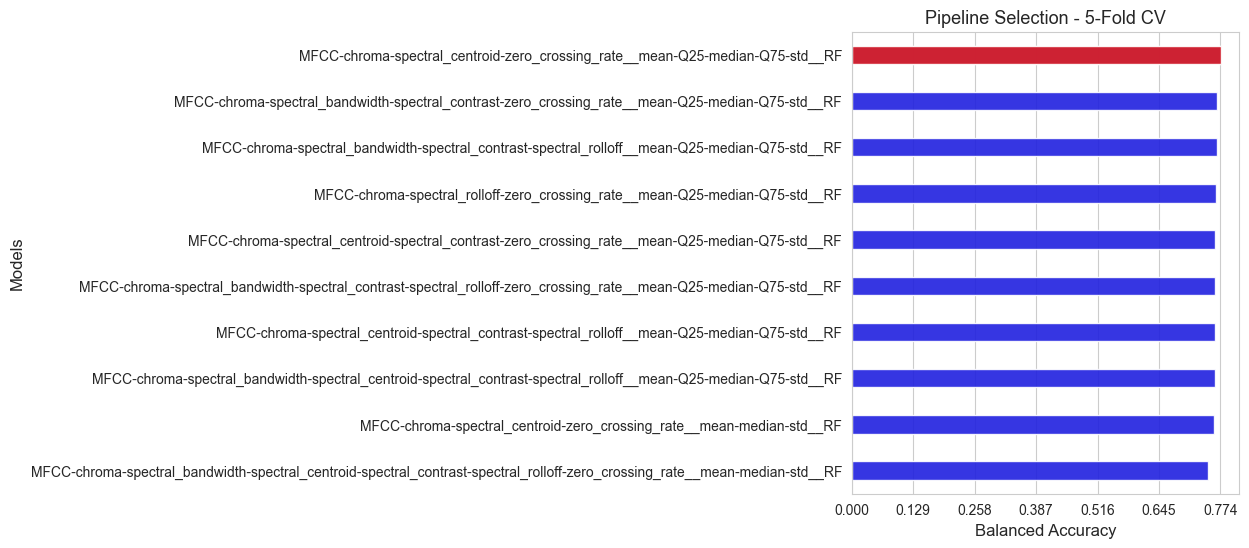

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_centroid-zero_crossing_rate__mean-Q25-median-Q75-std__RF
Balanced accuracy of the best pipeline:  0.774

 Best feature extraction method:  MFCC-chroma-spectral_centroid-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  RF

The best model hyper-parameters are:  {'n_estimators': 300, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [5]:
fig, axes = plt.subplots(figsize=(5,6))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

As we can see we have found a better version of Random Forest in this inner evaluation, so we have improved the previous results.

Remind that hte best inner score in the round 1 was a balanced accuracy of 67.3%, and now we have achieved 77.4%.

We save the top 5 features extraction methods to use them in the next inner evaluation round.

In [30]:
top_methods, top_stats = [], []
n_top = 5

for pipeline in sorted_pipelines[0:n_top]:
    top_methods.append(pipeline.split('__')[0])
    top_stats.append(pipeline.split('__')[1])

In [31]:
# Saving results 
'''
with open('results/top_methods_2', 'wb') as file:
    pickle.dump(top_methods, file)

with open('results/top_stats_2', 'wb') as file:
    pickle.dump(top_stats, file)
'''